Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [1]:
# all imports needed for this sheet

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [2]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [3]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'


In [4]:
df = pd.read_excel(DATA_PATH+'/Unit_2_project_data.xlsx')

In [5]:
exit_reasons = ['Rental by client with RRH or equivalent subsidy', 
                'Rental by client, no ongoing housing subsidy', 
                'Staying or living with family, permanent tenure', 
                'Rental by client, other ongoing housing subsidy',
                'Permanent housing (other than RRH) for formerly homeless persons', 
                'Staying or living with friends, permanent tenure', 
                'Owned by client, with ongoing housing subsidy', 
                'Rental by client, VASH housing Subsidy'
               ]

In [6]:
# pull all exit destinations from main data file and sum up the totals of each destination, 
# placing them into new df for calculations
exits = df['3.12 Exit Destination'].value_counts()

In [7]:
 # create target column (multiple types of exits to perm)
df['perm_leaver'] = df['3.12 Exit Destination'].isin(exit_reasons)

In [8]:
# base case
df['perm_leaver'].value_counts(normalize=True)

False    0.713086
True     0.286914
Name: perm_leaver, dtype: float64

In [9]:
# replace spaces with underscore
df.columns = df.columns.str.replace(' ', '_')

In [10]:
# see size of df prior to dropping empties
df.shape

(2025, 119)

In [11]:
# drop rows with no exit destination (current guests at time of report)
df = df.dropna(subset=['3.12_Exit_Destination'])

In [12]:
# shape of df after dropping current guests
df.shape

(1873, 119)

In [13]:
# verify no NaN in exit destination feature
df['3.12_Exit_Destination'].isna().value_counts()

False    1873
Name: 3.12_Exit_Destination, dtype: int64

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

train = df

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['perm_leaver'], random_state=42)

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # drop any private information
    X = X.drop(columns=['3.1_FirstName', '3.1_LastName', '3.2_SocSecNo', 
                      '3.3_Birthdate', 'V5_Prior_Address'])
    
    # drop unusable columns
    X = X.drop(columns=['2.1_Organization_Name', '2.4_ProjectType',
                        'WorkSource_Referral_Most_Recent', 'YAHP_Referral_Most_Recent',
                        'SOAR_Enrollment_Determination_(Most_Recent)',
                        'R7_General_Health_Status', 'R8_Dental_Health_Status',
                        'R9_Mental_Health_Status', 'RRH_Date_Of_Move-In',
                        'RRH_In_Permanent_Housing', 'R10_Pregnancy_Due_Date',
                        'R10_Pregnancy_Status', 'R1_Referral_Source',
                        'R2_Date_Status_Determined', 'R2_Enroll_Status',
                        'R2_Reason_Why_No_Services_Funded', 'R2_Runaway_Youth',
                        'R3_Sexual_Orientation', '2.5_Utilization_Tracking_Method_(Invalid)',
                        '2.2_Project_Name', '2.6_Federal_Grant_Programs', '3.16_Client_Location',
                        '3.917_Stayed_Less_Than_90_Days', 
                        '3.917b_Stayed_in_Streets,_ES_or_SH_Night_Before', 
                        '3.917b_Stayed_Less_Than_7_Nights', '4.24_In_School_(Retired_Data_Element)',
                        'CaseChildren', 'ClientID', 'HEN-HP_Referral_Most_Recent',
                        'HEN-RRH_Referral_Most_Recent', 'Emergency_Shelter_|_Most_Recent_Enrollment',
                        'ProgramType', 'Days_Enrolled_Until_RRH_Date_of_Move-in',
                        'CurrentDate', 'Current_Age', 'Count_of_Bed_Nights_-_Entire_Episode',
                        'Bed_Nights_During_Report_Period'])
        
    # drop rows with no exit destination (current guests at time of report)
    X = X.dropna(subset=['3.12_Exit_Destination'])
    
    # remove columns to avoid data leakage
    X = X.drop(columns=['3.12_Exit_Destination', '5.9_Household_ID', '5.8_Personal_ID',
                       '4.2_Income_Total_at_Exit', '4.3_Non-Cash_Benefit_Count_at_Exit'])
    
    # Drop needless feature
    unusable_variance = ['Enrollment_Created_By', '4.24_Current_Status_(Retired_Data_Element)']
    X = X.drop(columns=unusable_variance)

    # Drop columns with timestamp
    timestamp_columns = ['3.10_Enroll_Date', '3.11_Exit_Date', 
                         'Date_of_Last_ES_Stay_(Beta)', 'Date_of_First_ES_Stay_(Beta)', 
                         'Prevention_|_Most_Recent_Enrollment', 'PSH_|_Most_Recent_Enrollment', 
                         'Transitional_Housing_|_Most_Recent_Enrollment', 'Coordinated_Entry_|_Most_Recent_Enrollment', 
                         'Street_Outreach_|_Most_Recent_Enrollment', 'RRH_|_Most_Recent_Enrollment', 
                         'SOAR_Eligibility_Determination_(Most_Recent)', 'Date_of_First_Contact_(Beta)',
                         'Date_of_Last_Contact_(Beta)', '4.13_Engagement_Date', '4.11_Domestic_Violence_-_When_it_Occurred',
                         '3.917_Homeless_Start_Date']
    X = X.drop(columns=timestamp_columns)
    
    # return the wrangled dataframe
    return X



In [15]:
train = wrangle(train)
val = wrangle(val)

In [16]:
train.columns

Index(['3.15_Relationship_to_HoH', 'CaseMembers',
       '3.2_Social_Security_Quality', '3.3_Birthdate_Quality',
       'Age_at_Enrollment', '3.4_Race', '3.5_Ethnicity', '3.6_Gender',
       '3.7_Veteran_Status', '3.8_Disabling_Condition_at_Entry',
       '3.917_Living_Situation', '3.917_Length_of_Stay',
       'Length_of_Time_Homeless_(3.917_Approximate_Start)',
       '3.917_Times_Homeless_Last_3_Years',
       '3.917_Total_Months_Homeless_Last_3_Years', 'V5_Last_Permanent_Address',
       'V5_State', 'V5_Zip', 'Municipality_(City_or_County)',
       'Days_Enrolled_in_Project', '4.1_Housing_Status',
       '4.4_Covered_by_Health_Insurance', '4.11_Domestic_Violence',
       '4.11_Domestic_Violence_-_Currently_Fleeing_DV?',
       'Days_Enrolled_Until_Engagement_Date',
       '4.24_Connected_to_McKinney_Vento_Liason_(Retired)', 'Household_Type',
       'Latitude', 'Longitude', 'R4_Last_Grade_Completed', 'R5_School_Status',
       'R6_Employed_Status', 'R6_Why_Not_Employed', 'R6_Type_of

In [20]:
# Assign to X, y to avoid data leakage
features = ['3.15_Relationship_to_HoH', 'CaseMembers',
       '3.2_Social_Security_Quality', '3.3_Birthdate_Quality',
       'Age_at_Enrollment', '3.4_Race', '3.5_Ethnicity', '3.6_Gender',
       '3.7_Veteran_Status', '3.8_Disabling_Condition_at_Entry',
       '3.917_Living_Situation', 'Length_of_Time_Homeless_(3.917_Approximate_Start)',
       '3.917_Times_Homeless_Last_3_Years', '3.917_Total_Months_Homeless_Last_3_Years', 
       'V5_Last_Permanent_Address', 'V5_State', 'V5_Zip', 'Municipality_(City_or_County)',
       '4.1_Housing_Status', '4.4_Covered_by_Health_Insurance', '4.11_Domestic_Violence',
       '4.11_Domestic_Violence_-_Currently_Fleeing_DV?', 'Household_Type', 
       'R4_Last_Grade_Completed', 'R5_School_Status',
       'R6_Employed_Status', 'R6_Why_Not_Employed', 'R6_Type_of_Employment',
       'R6_Looking_for_Work', '4.2_Income_Total_at_Entry',
       '4.3_Non-Cash_Benefit_Count', 'Barrier_Count_at_Entry',
       'Chronic_Homeless_Status', 'Under_25_Years_Old',
       '4.10_Alcohol_Abuse_(Substance_Abuse)', '4.07_Chronic_Health_Condition',
       '4.06_Developmental_Disability', '4.10_Drug_Abuse_(Substance_Abuse)',
       '4.08_HIV/AIDS', '4.09_Mental_Health_Problem',
       '4.05_Physical_Disability'
          ]
target = 'perm_leaver'
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [18]:
# Arrange data into X features matrix and y target vector
target = 'perm_leaver'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]


In [19]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(5, 500, 5), 
    'max_depth': [10, 15, 20, 50, 'None'], 
    'max_features': [.5, 1, 1.5, 2, 2.5, 3, 'sqrt', None],
    
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=20, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1931s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1134s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


ValueError: could not convert string to float: 'Self'

In [21]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features=None, random_state=42
                       )
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.744


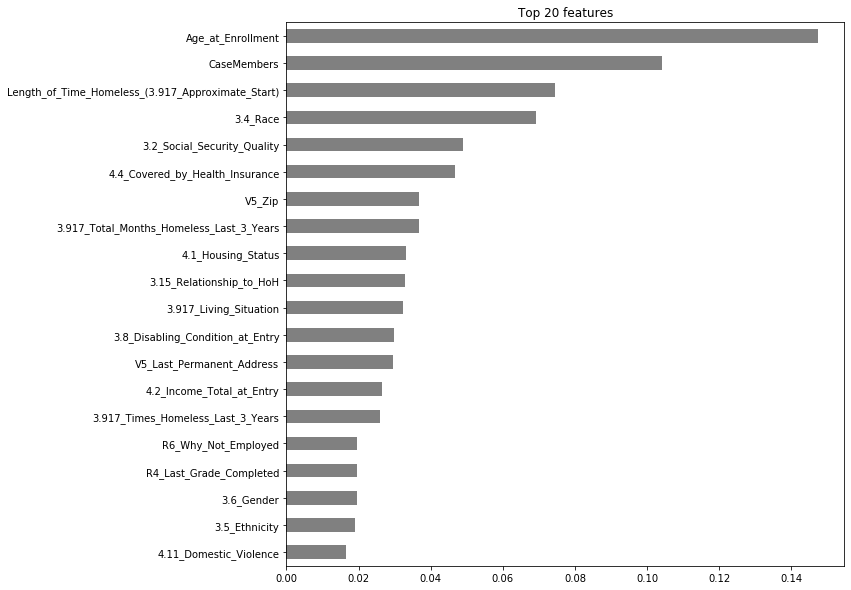

In [22]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [ ]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    xgb.XGBClassifier(n_estimators=110, n_jobs=-1, num_parallel_tree=200,
                           random_state=42
                       )
)
# Fit on Train
pipeline.fit(X_train, y_train)

In [ ]:
# Score on val
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

In [ ]:
# cross validation 

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'MAE for {k} folds:', -scores)

In [ ]:
-scores.mean()

In [ ]:
# get and plot feature importances

# Linear models have coefficients whereas decision trees have "Feature Importances"
import matplotlib.pyplot as plt

model = pipeline.named_steps['xgbclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey')

In [ ]:
df['4.1_Housing_Status'].value_counts()

In [ ]:
X_train.shape

In [ ]:
X_train.columns

In [ ]:
X_train.Days_Enrolled_in_Project.value_counts()

In [ ]:
column  = 'Days_Enrolled_in_Project'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

In [ ]:
column  = 'Days_Enrolled_in_Project'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=250, max_depth=7, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=250, max_depth=7, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

In [ ]:
# Fit with all the data
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

In [ ]:
# Before: Sequence of features to be permuted
feature = 'Days_Enrolled_in_Project'
X_val[feature].head()

In [ ]:
# Before: Distribution of quantity
X_val[feature].value_counts()

In [ ]:
# Permute the dataset
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

In [ ]:
# After: Sequence of features to be permuted
X_val_permuted[feature].head()

In [ ]:
# Distribution hasn't changed!
X_val_permuted[feature].value_counts()

In [ ]:
# Get the permutation importance
score_permuted = pipeline.score(X_val_permuted, y_val)

print(f'Validation Accuracy with {column} not permuted: {score_with}')
print(f'Validation Accuracy with {column} permuted: {score_permuted}')
print(f'Permutation Importance for {column}: {score_with - score_permuted}')

In [ ]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent')
)

X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

In [ ]:
pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

In [ ]:
permuter.feature_importances_

In [ ]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

In [ ]:
print('Shape before removing features:', X_train.shape)

In [ ]:
minimum_importance = 0 
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [ ]:
print('Shape after removing features:', X_train.shape)

In [ ]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

In [ ]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

In [ ]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(n_estimators=1000,    # <= 1000 trees, early stopping depency
                      max_depth=7,          # try deeper trees with high cardinality data
                      learning_rate=0.1,    # try higher learning rate
                      random_state=42,
                      num_class=1,
                      n_jobs=-1)

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

# Fit on train, score on val
model.fit(X_train_encoded, y_train,
          eval_metric='auc',
          eval_set=eval_set, 
          early_stopping_rounds=25)

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
results = model.evals_result()
train_error = results['validation_0']['auc']
val_error = results['validation_1']['auc']

iterations = range(1, len(train_error) + 1)

plt.figure(figsize=(10,7))
plt.plot(iterations, train_error, label='Train')
plt.plot(iterations, val_error, label='Validation')
plt.title('XGBoost Validation Curve')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();